In [0]:
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import os 
import random
import time
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.transforms import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter


from matplotlib import pyplot as plt
from PIL import Image

In [0]:
 data_root = './'
#data_root = '/kaggle/input/pytorch-opencv-course-classification/'

image_root = os.path.join(data_root, 'images/images')
data_csv_path = os.path.join(data_root, 'train.csv')
test_csv_path = os.path.join(data_root, 'test.csv')
train_csv='train.csv'
val_csv='validation.csv'
valid_fraction=0.2

In [0]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [0]:
def split_train_validation(csv_path, valid_fraction=0.2, train_csv='train.csv', val_csv='validation.csv', print_info=True):
    """
    It takes .csv file that have two column: ['id', 'class'] and create two .csv file for traing and validation. Return a list of classes
    Parms:
    csv_path (str): path of data csv
    valid_fraction (float): fraction for validation data (0 to 1). 
    train_csv (str): train data file path
    val_csv (str): validation data file path
    print_info (boolean): True for print data overview else False
    
    return (list): List of classes 
    """
    data_df = pd.read_csv(csv_path)

    classes = list(data_df['class'].unique())
    
    if print_info:
        print('There is {} classes and its names are the following:\n{}\n'.format(len(classes), classes))
        
    f_val = open(val_csv, 'w')
    f_train = open(train_csv, 'w')
    
    f_val.write('{},{}\n'.format('id', 'class'))
    f_train.write('{},{}\n'.format('id', 'class'))
        
    for i, cls in enumerate(classes):
        cls_data = data_df[data_df['class']==cls]['id'].to_list()
        val_count = int(len(cls_data) * valid_fraction)
        val_data = random.sample(cls_data, k=val_count)
        
        if print_info:
            print('{}.\tCLASS NAME: {}\tTRAIN COUNT: {}\tVALIDATION COUNT: {}'.format(i, cls, len(cls_data)-len(val_data), len(val_data)))
        for img_id in cls_data:
            if img_id in val_data:
                f_val.write('{},{}\n'.format(img_id, cls))
            else:
                f_train.write('{},{}\n'.format(img_id, cls))
    f_val.close()
    f_train.close()
    
    return classes

In [39]:
class_names = split_train_validation(csv_path=data_csv_path, 
                                     valid_fraction=valid_fraction, 
                                     train_csv=train_csv, 
                                     val_csv=val_csv, 
                                     print_info=True)

There is 13 classes and its names are the following:
['githeri', 'ugali', 'kachumbari', 'matoke', 'sukumawiki', 'bhaji', 'mandazi', 'kukuchoma', 'nyamachoma', 'pilau', 'chapati', 'masalachips', 'mukimo']

0.	CLASS NAME: githeri	TRAIN COUNT: 308	VALIDATION COUNT: 76
1.	CLASS NAME: ugali	TRAIN COUNT: 403	VALIDATION COUNT: 100
2.	CLASS NAME: kachumbari	TRAIN COUNT: 317	VALIDATION COUNT: 79
3.	CLASS NAME: matoke	TRAIN COUNT: 310	VALIDATION COUNT: 77
4.	CLASS NAME: sukumawiki	TRAIN COUNT: 258	VALIDATION COUNT: 64
5.	CLASS NAME: bhaji	TRAIN COUNT: 405	VALIDATION COUNT: 101
6.	CLASS NAME: mandazi	TRAIN COUNT: 397	VALIDATION COUNT: 99
7.	CLASS NAME: kukuchoma	TRAIN COUNT: 112	VALIDATION COUNT: 27
8.	CLASS NAME: nyamachoma	TRAIN COUNT: 503	VALIDATION COUNT: 125
9.	CLASS NAME: pilau	TRAIN COUNT: 212	VALIDATION COUNT: 52
10.	CLASS NAME: chapati	TRAIN COUNT: 552	VALIDATION COUNT: 138
11.	CLASS NAME: masalachips	TRAIN COUNT: 281	VALIDATION COUNT: 70
12.	CLASS NAME: mukimo	TRAIN COUNT: 136	VALIDATIO

In [40]:
df = pd.read_csv(val_csv)
print(df.head())
print(df.tail())

                     id    class
0   4222441716327528413  githeri
1   4939671543203955477  githeri
2  11046471567567707496  githeri
3  10526888018530471027  githeri
4    255658809211593677  githeri
                        id   class
1037  17007731591344275740  mukimo
1038   6875531799312516842  mukimo
1039   8458813849280411843  mukimo
1040  13565196064532595911  mukimo
1041   7039809651508355803  mukimo


In [0]:
class KenyanFood13Dataset(Dataset):
    """
    This custom dataset class take root image directory and csv path
    and return dataset
    """
    
    def __init__(self, image_root, csv_path, classes, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         image_root (string): path of image directory.
         
         csv_path (string): path of train, val or test csv
         
         classes (list): a list of classes 
         
         image_shape (int or tuple or list): [optional] (height, width) int or tuple or list. Defaut is None. 
                                             It is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transforms it.
         
        """
        
        self.image_root = image_root
        
        data_df = pd.read_csv(csv_path)
        
        self.classes = classes
        
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError
        else:
            self.image_shape = image_shape
            
        # set transform attribute
        self.transform = transform
                
        
        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        
        cols = data_df.columns
        for i in range(len(data_df)):
            img_id = data_df['id'][i]
            image_path = os.path.join(image_root, '{}.jpg'.format(img_id))
            
            # making compatible with test data also
            if 'class' in cols:
                cls = data_df['class'][i]
                cls_idx = self.classes.index(cls)
                assert 0 <= cls_idx <= 12
            else: 
                cls_idx = None
                
            self.data_dict['image_path'].append(image_path)
            self.data_dict['label'].append(cls_idx)
        
                    
    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")
        
        if self.image_shape is not None:
            height, width = self.image_shape
            image = F.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.data_dict['label'][idx]
        
        return image, target            
                
        
    def classes(self, label):
        """
        Get class names
        """
        return self.classes
    
    def class_to_index(self, class_name):
        """
        Get index of the class
        """
        return self.classes.index(class_name)
    
    def index_to_class(self, class_index):
        """
        Get class name for the class index
        """
        
        return self.classes[class_index]

Length of the dataset: 1042
Label: 3, Class name: matoke


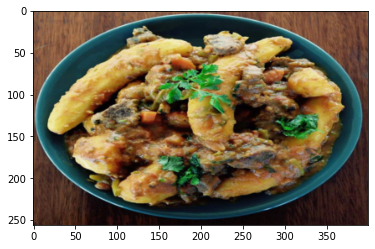

In [42]:
val_dataset =  KenyanFood13Dataset(image_root=image_root, csv_path=val_csv, classes=class_names, image_shape=(256, 400))

print('Length of the dataset: {}'.format(len(val_dataset)))

img, trgt = val_dataset[300]

print('Label: {}, Class name: {}'.format(trgt, val_dataset.index_to_class(trgt)))
plt.imshow(img)
plt.show()

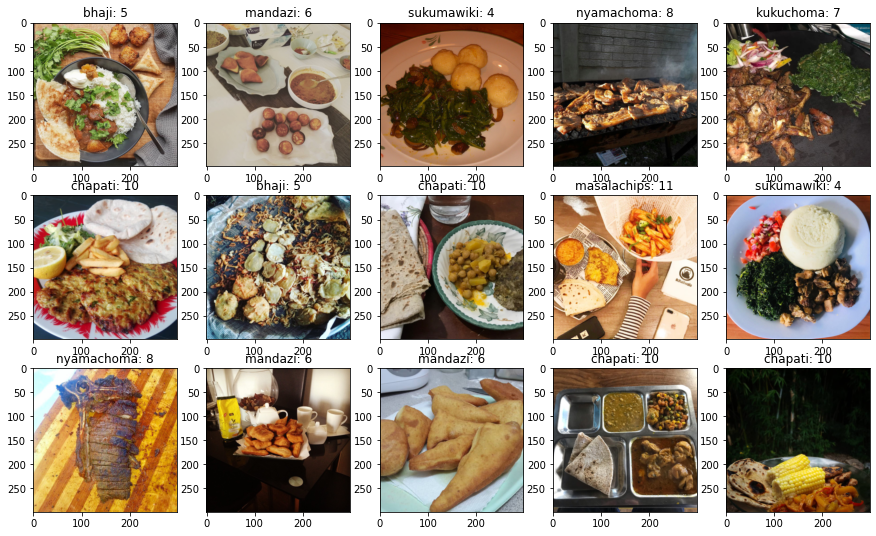

In [43]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor()
    ])

val_dataset =  KenyanFood13Dataset(image_root=image_root, csv_path=val_csv, classes=class_names, image_shape=None, transform=preprocess)

# dataloader with dataset
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=2
    )


# Plot few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels in val_loader:
    for i in range(len(labels)):
        plt.subplot(3, 5, i+1)
        img = F.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('{}: {}'.format(val_dataset.index_to_class(labels[i]), labels[i]))
    plt.show()
    break

In [0]:
def image_common_transforms(mean, std):
    
    preprocess = transforms.Compose([
        transforms.Resize(299,299),
        transforms.CenterCrop(299),
        transforms.ToTensor()
        ])
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

In [0]:
def data_augmentation_preprocess(mean, std):
    
    initail_transoform = transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90),
        ])
    
    preprocess = transforms.Compose([
        transforms.RandomAffine(degrees=120, translate=(0.2, 0.2), scale=(0.8, 1.2), 
                                shear=(-20, 20, -20, 20), resample=False, fillcolor=(0, 0,0)),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), 
                                 value='random', inplace=False),
        transforms.Resize(299,299),
        transforms.RandomCrop(299),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])
                
    aug_transforms = transforms.Compose([
        initail_transoform,
        transforms.RandomGrayscale(p=0.1),
        preprocess
        ])
    
    return aug_transforms

In [0]:
def data_loader(image_root, csv_path, classes, transform, batch_size=4, shuffle=False, num_workers=2):
    dataset =  KenyanFood13Dataset(image_root, csv_path, classes, transform=preprocess)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [0]:
def get_mean_std():
    
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    
    return mean, std

In [0]:
def get_data(batch_size, num_workers=4, data_augmentation=True):
           
    mean, std = get_mean_std()
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    train_loader = data_loader(image_root, 
                               train_csv, 
                               class_names, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    test_loader = data_loader(image_root,
                              val_csv,
                              class_names,
                              common_transforms, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    
    return train_loader, test_loader

In [0]:
# %load_ext tensorboard
# # %reload_ext tensorboard

# %tensorboard --logdir logs/resnet18

## <font style="color:green">System Configuration</font>

In [0]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

## <font style="color:green">Training Configuration</font>

In [0]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 4 
    epochs_count: int = 20 
    init_learning_rate: float = 0.001  # initial learning rate for lr scheduler
    decay_rate: float = 0.1  
    log_interval: int = 20  
    test_interval: int = 1  
    num_workers: int = 16 
    device: str = 'cuda'

## <font style="color:green">System Setup</font>

In [0]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">Training Function</font>

We are familiar with the training pipeline used in PyTorch.

In [0]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = nn.functional.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = nn.functional.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            
            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)
            print('Batch: {0}\tTrain Loss: {1:.4f}\tAccuracy: {2:.3f}'.format(int(total_batch), loss.item(), acc))
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    
    return epoch_loss, epoch_acc

## <font style="color:green">Validation Function</font>

In [0]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += nn.functional.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = nn.functional.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [0]:
def save_model(model, device, model_dir='models', model_file_name='final_model.pt'):
    
    train_config = TrainingConfiguration()
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device[:4] == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device[:4] == 'cuda':
        model.to(device)
    
    return

## <font style="color:blue">4.5. Load the Model</font>

In [0]:
def load_model(model, model_dir='models', model_file_name='final_model.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [0]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return

## <font style="color:green">Main Function for Training and Validation</font>

In this section of code, we use the configuration parameters defined above and start the training. Here are the important actions being taken in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc
1. Load the data using dataloaders
1. For each epoch, call train function, and for every test interval, call validation function.
1. Do `scheduler.step()` to update learning rate for next epoch.
1. Set up variables to track loss and accuracy and start training.

In [0]:
def main(model, optimizer, tb_writer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=False, model_name='final_model1.pt'):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = training_configuration.device
    else:
        device = "cpu"
        batch_size_to_set = 4
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, init_val_accuracy*100))
    
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
        # add scalar (loss/accuracy) to tensorboard
        tb_writer.add_scalar('Loss/Train',train_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', train_acc, epoch)

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )
        
        # add time metadata to tensorboard
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)
        

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            # add scalar (loss/accuracy) to tensorboard
            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device, model_file_name=model_name)
                
        
        # scheduler step/ update learning rate
        # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:green">Optimizer and Scheduler</font>

Let's write optimizer and scheduler as a method because we have to use it in all training experiments.

In [0]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr = init_learning_rate,
        momentum = 0.9
    )
    
    factor = 0.5  # reduce by factor 0.5
    patience = 2  # epochs
    verbose = True
    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose)
    
    return optimizer, scheduler

# <font style="color:blue">ResNet Model</font>
We will load the resnet18 model with its pretrained weights.

The layers are configured such that if you pass the transfer_learning flag, it just replaces the last layers of the network. Otherwise, it will retrain all layers, but with the pretrained weights, not from scratch.

In [0]:
# def pretrained_resnet18(transfer_learning=True, num_class=3):
#     resnet = models.resnet18(pretrained=True)
    
#     if transfer_learning:
#         for param in resnet.parameters():
#             param.requires_grad = False
            
#     last_layer_in = resnet.fc.in_features
#     resnet.fc = nn.Linear(last_layer_in, num_class)
    
#     return resnet

# def pretrained_inception_v3(transfer_learning=True, num_class=3):
#     inception_v3 = models.inception_v3(pretrained=True)
    
#     if transfer_learning:
#         for param in inception_v3.parameters():

#             param.requires_grad = False
            
#     last_layer_in = inception_v3.fc.in_features
#     inception_v3.fc = nn.Linear(last_layer_in, num_class)
    
#     return inception_v3



def pretrained_inception_v3(transfer_learning=True, num_class=3):
  inception_v3 = models.inception_v3(pretrained=True)

  if transfer_learning:
    for param in inception_v3.parameters():
      param.required_grad = False

  last_layer_in = inception_v3.fc.in_features
  inception_v3.fc = nn.Linear(last_layer_in,num_class)

  return inception_v3

In [0]:
# def inception_v3(feature_extract=True, num_class=13):
#     model = models.inception_v3(pretrained=True)

    
#     if feature_extract:
#         for param in model.parameters():
#             param.requires_grad = False
            
# #         for param in model.layer3.parameters():
# #             param.requires_grad = True
            
#         for param in model.Mixed_7c.parameters():
#             param.requires_grad = True
            
            
    

                              
#     last_layer_in = model.fc.in_features
#     model.fc = nn.Linear(last_layer_in, num_class)
    
#     return model

#####################################################################
def inception_v3(feature_extract= True, num_class=13):
  model =models.inception_v3(pretrained=True,aux_logits=False)

  if feature_extract:
    for param in model.parameters():
      param.requires_grad = False


    for param in model.Mixed_7c.parameters():
      
      param.requires_grad=True
      


    # for param in model.parameters():
    #   param.aux_logits = False




    last_layer_in = model.fc.in_features

    model.fc = nn.Linear(last_layer_in , num_class)


  return model


################################################
# def inception_v3(feature_extract=True, num_class=13):
#     model = models.inception_v3(pretrained=True)

    
#     if feature_extract:
#         for param in model.parameters():

#             param.requires_grad = False

#         for param in model.parameters():
#           param.aux_logits = False



            
            
# #         for param in model.layer3.parameters():
# #             param.requires_grad = True
            
#         # for param in model.Mixed_7c.parameters():
#         #     param.requires_grad = True
            
            
    

                              
#     last_layer_in = model.fc.in_features
#     model.fc = nn.Linear(last_layer_in, num_class)
    
#     return model









# def inception_v3(pretrained=False, progress=True, **kwargs):
#     r"""Inception v3 model architecture from
#     `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
#     .. note::
#         **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
#         N x 3 x 299 x 299, so ensure your images are sized accordingly.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#         aux_logits (bool): If True, add an auxiliary branch that can improve training.
#             Default: *True*
#         transform_input (bool): If True, preprocesses the input according to the method with which it
#             was trained on ImageNet. Default: *False*
#     """
#     if pretrained:
#         if 'transform_input' not in kwargs:
#             kwargs['transform_input'] = True
#         if 'aux_logits' in kwargs:
#             original_aux_logits = kwargs['aux_logits']
#             kwargs['aux_logits'] = True
#         else:
#             original_aux_logits = True
#         model = Inception3(**kwargs)
#         state_dict = load_state_dict_from_url(model_urls['inception_v3_google'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#         if not original_aux_logits:
#             model.aux_logits = False
#             del model.AuxLogits
#         return model

#     return Inception3(**kwargs)

In [0]:
def resnext50_32x4d(transfer_learning=True, num_class=13):
    model = models.resnext50_32x4d(pretrained=True)
    
    if transfer_learning:
        for param in model.parameters():
          
            param.requires_grad = False
            

            
        for param in model.layer4.parameters():
            param.requires_grad = True
            
            
    

                              
    last_layer_in = model.fc.in_features
    model.fc = nn.Linear(last_layer_in, num_class)
    
    return model

In [0]:
class PreTrainedModel(nn.Module):
    def __init__(self, model_name, freeze_layers, num_class):
        super().__init__()

        # convolution layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        mod = getattr(models, model_name)(pretrained=True)
        
        self.features = mod.features
        
        for name, param in self.features.named_parameters():
            
            if int(name.split('.')[0]) == freeze_layers:
                break
                
            if param.requires_grad:
                param.requires_grad = False
                
        self.avgpool = mod.avgpool
            
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            
            nn.Linear(in_features=25088, out_features=4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(in_features=4096, out_features=1024), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(in_features=1024, out_features=num_class)
        )

    def forward(self, x):
        x = self.features(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size()[0], -1)
        
        x = self.classifier(x)
        return x

# <font style="color:blue">Transfer Learning</font>

In [64]:
model_name = 'inception_v3_with_layers'

freeze_layers = 20

num_class = len(class_names)

#model = PreTrainedModel(model_name, freeze_layers, num_class)
#model = resnext50_32x4d()
model = inception_v3()
#model = torch.hub.load('pytorch/vision:v0.5.0', 'inception_v3', pretrained=True,aux_logits=False,feature_extracting = True,requires_grad=False)
 
#model=Inception_v3(.../,weights='imagenet',include_top=False)


print(model)
# get optimizer and scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# Tensorboard summary writer
logs = 'pretrained2/{}_{}'.format(model_name, freeze_layers)
transfer_learning_sw = SummaryWriter(logs)  

model_name = '{}_{}.pt'.format(model_name, freeze_layers)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth



Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, 

In [65]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, 
                                                       optimizer,
                                                       transfer_learning_sw,
                                                       scheduler,
                                                       data_augmentation=True,
                                                       model_name=model_name)
transfer_learning_sw.close()


Test set: Average loss: 2.5996, Accuracy: 63/1042 (6%)

Initial Test Loss : 2.599594, 
Initial Test Accuracy : 6.046%

Batch: 20	Train Loss: 2.5719	Accuracy: 0.000
Batch: 40	Train Loss: 2.3513	Accuracy: 0.000
Batch: 60	Train Loss: 2.2524	Accuracy: 0.250
Batch: 80	Train Loss: 2.1184	Accuracy: 0.500
Batch: 100	Train Loss: 2.6172	Accuracy: 0.000
Batch: 120	Train Loss: 2.3457	Accuracy: 0.500
Batch: 140	Train Loss: 1.8766	Accuracy: 0.500
Batch: 160	Train Loss: 1.4208	Accuracy: 0.500
Batch: 180	Train Loss: 2.8313	Accuracy: 0.000
Batch: 200	Train Loss: 3.0986	Accuracy: 0.000
Batch: 220	Train Loss: 1.2311	Accuracy: 0.500
Batch: 240	Train Loss: 2.6831	Accuracy: 0.000
Batch: 260	Train Loss: 3.0098	Accuracy: 0.000
Batch: 280	Train Loss: 2.2922	Accuracy: 0.500
Batch: 300	Train Loss: 2.6977	Accuracy: 0.500
Batch: 320	Train Loss: 1.8784	Accuracy: 0.500
Batch: 340	Train Loss: 1.9053	Accuracy: 0.750
Batch: 360	Train Loss: 1.8345	Accuracy: 0.500
Batch: 380	Train Loss: 1.4347	Accuracy: 0.750
Batch: 400

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

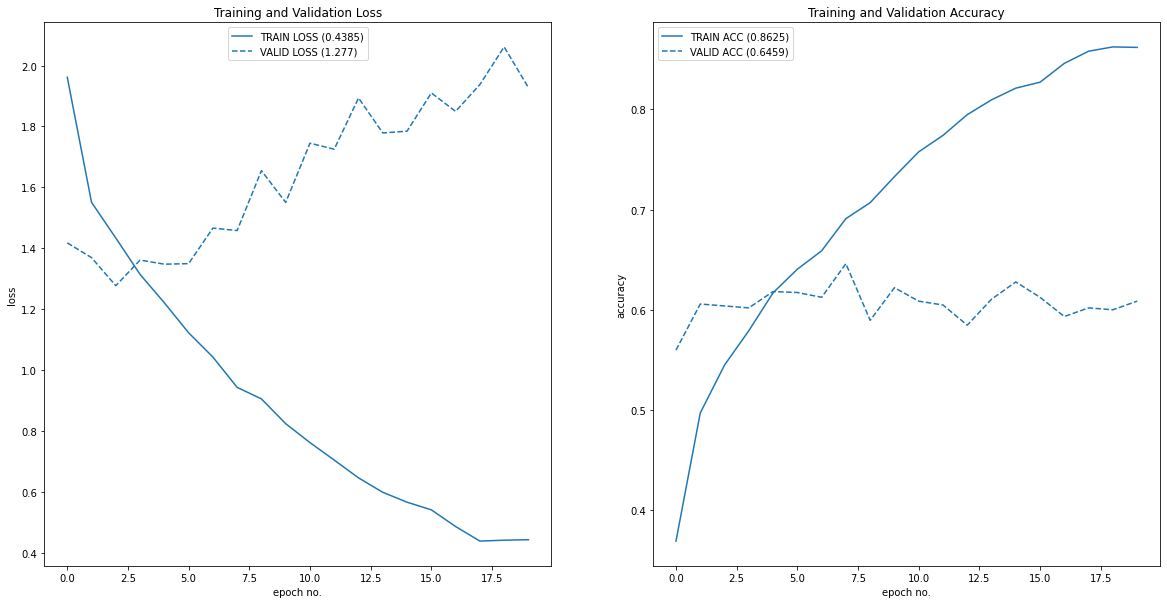

In [66]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')